# Bank Customer Churn Prediction / Data Exploratory Analysis

```
Required Dataset: Bank Customer Churn dataset
Dataset Link:
https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/data
```

In [1]:
# Import neccessary libraries for this task
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
# Import these clases from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Load Dataset
The downloaded bank customer churn dataset will be read in using pandas for analysis

In [3]:
# Read in dataset using pandas
customer_churn_df = pd.read_csv("./Customer-Churn-Records.csv")

In [4]:
# Display the first 5 rows
customer_churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [5]:
# Keep a copy of this dataframe
customer_churn_df_copy = customer_churn_df.copy()

In [6]:
# Observe dataset information
customer_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [7]:
# As can be observed from .info there are no null values
# Confirm if the dataset is free from duplicate rows
customer_churn_df.duplicated().sum()

0

## Exploratory Data Analysis/Model Predicition
Based on the column definitions given on kaggle for this dataset, I will be performing the following task
- Drop irrelevant columns that won't add to prediction (eg., RowNumber, CustomerId, Surname)
- Create independent (X) and dependent (y) features and split
- Train model for prediction
- Evaluate model on test data

In [8]:
# Drop irrelevant column and directly apply it to the dataframe
customer_churn_df.drop(columns=["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

# Display the first 5 rows to see effected changes
customer_churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### Correlation of all numerical features (target inclusive)
This is helpful to check the correlation between all numerical features with the target feature `Exited`. It gives a sense of understanding as to which of the numerical features provides the highest correlation with the target variable `Exited`. 

In [9]:
# Now extract all numeric columns including target for correlation analysis
corr_df = customer_churn_df.select_dtypes(include=[np.number])

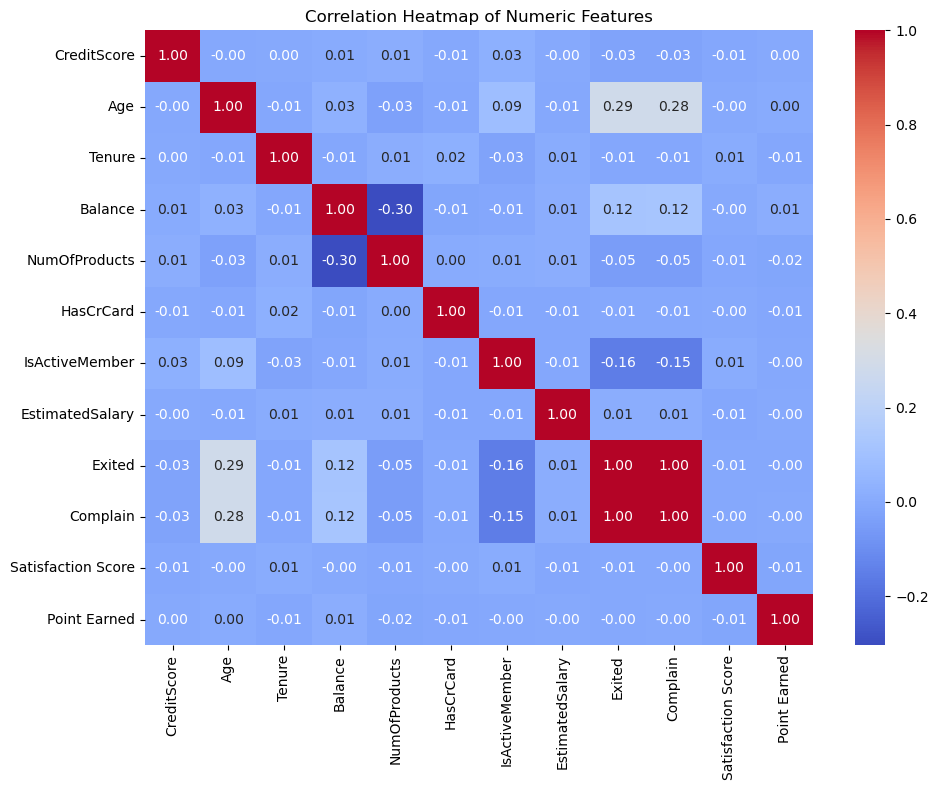

In [10]:
# Compute correlation matrix to see relationship, 
# Of each numerical feature against 'Exited'
corr_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# Add title
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
# Show plot
plt.show()

As displayed by the correlation matrix above, it can be observed that the column `Complain` had a perfect 1.0 correlation with the target `Exited` and vice-versa. Also, if you look at both axis of `Complain` and `Exited` side by side, one can tell that the values are literally the same across the two columns. This is very unusual, the usual occurrence is having a 1.0 along the diagonal line of the correlation matrix which signifies the relationship of a column with itself. 

**A correlation of 1.0 is powerful but it’s also suspicious. What it implies is that `Complain` perfectly predicts customer churn i.e `Exited` in the dataset:**
- Every time a customer complained, they churned
- Every time a customer did not complain, they did not churn

**Reasons why could be:**
- Data leakage: `Complain` might be derived from or directly tied to the target. For example, if `Complain` was recorded after the customer churned `(Exited)`, it’s not a valid predictor

**Problems:**
- Overfitting risk: Including `Complain` in the model could make it overly reliant on that feature, reducing generalizability


## Numerical Features (`Complain` inclusive)
I got thinking, then I feel I should see the impact of using just numerical columns to predict the bank customer churn and also using the combination of numerical columns and onehot encoded categorical columns and compare if indeed the categorical columns like `(Gender, Geography, Card Type)` add more predictive values
- For now, numerical columns will be considered i.e all columns except categorical columns

In [11]:
# Create independent features (Xn) by dropping categorical columns and target variable
Xn = customer_churn_df.drop(columns=["Gender", "Geography", "Card Type", "Exited"], axis=1)

# y is the target "Exited"
y = customer_churn_df["Exited"]

# Split the features into train and test sets
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Confirm the splitted data is in the right shape
print(f"Xn shape : {Xn.shape}")
print(f"y shape : {y.shape}")
print(f"Xn_train shape : {Xn_train.shape}")
print(f"y_train shape : {y_train.shape}")

Xn shape : (10000, 11)
y shape : (10000,)
Xn_train shape : (8000, 11)
y_train shape : (8000,)


## Classification Models for Prediction
Four classfication model will be employed `logisticRegression`, `RandomForestClassifier`, and `XGBoostClassifier`
- Each of these models will be tested to predict bank customers who churned
- Confusion matrix to visualise classification

```
# Reuseable function to avoid boiler plate codes
train_churn_classification(X_train, X_test, y_train, y_test, model_type="all")
plot_churn_confusion_matrix(y_test, y_pred, model_name)
```

In [13]:
def train_churn_classification(X_train, X_test, y_train, y_test, model_type="all"):
    models = {
        "logistic_regression": LogisticRegression(max_iter=1000, random_state=42),
        "random_forest": RandomForestClassifier(random_state=42),
        "xgboost": xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    }

    valid_models = list(models.keys())
    results = []

    # Scaling setup (for Logistic Regression only)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply scaling to logistic regression only 
    def get_data(name):
        return (X_train_scaled, X_test_scaled) if name == "logistic_regression" else (X_train, X_test)

    if model_type == "all":
        for name, model in models.items():
            Xtr, Xte = get_data(name)
            model.fit(Xtr, y_train)
            y_pred = model.predict(Xte)

            results.append({
                "model": name,
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
                "recall": recall_score(y_test, y_pred, average='weighted'),
                "f1_score": f1_score(y_test, y_pred, average='weighted')
            })
        
        results_df = pd.DataFrame(results).sort_values(by="f1_score", ascending=False).reset_index(drop=True)
        best_model = results_df.loc[results_df['f1_score'].idxmax()]

        print("\nModel Performance Summary:")
        print(results_df)
        print(f"\nBest Model: {best_model['model']} "
              f"(F1-score: {best_model['f1_score']:.4f}, Accuracy: {best_model['accuracy']:.4f})")

        return results_df

    elif model_type in valid_models:
        model = models[model_type]
        Xtr, Xte = get_data(model_type)
        model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print(f"accuracy : {accuracy:.4f}, f1_score : {f1:.4f}")
        print(f"\nClassification Report for {model_type}:")
        print(classification_report(y_test, y_pred))

        return {
            "model": model,
            "y_test": y_test,
            "y_pred": y_pred
        }
    
    else:
        raise ValueError(f"Invalid model_type. Choose from {valid_models} or 'all'.")


In [14]:
def plot_churn_confusion_matrix(y_test, y_pred, model_name):
    """
    Plots the confusion matrix for a classification model.

    Parameters:
    - y_test: Ground truth target values.
    - y_pred: Predicted target values.
    - model_name: Name of the model (used for the plot title).
    """
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {model_name}")
    
    # Show plot
    plt.show()

### Model Prediction (`Complain` column inclusive)

In [15]:
# Use model_type=all to see all Model Performance Summary dataframe
all_num_cl = train_churn_classification(X_train=Xn_train, X_test=Xn_test, y_train=y_train, y_test=y_test, model_type="all")


Model Performance Summary:
                 model  accuracy  precision  recall  f1_score
0  logistic_regression    0.9985   0.998499  0.9985  0.998499
1        random_forest    0.9985   0.998499  0.9985  0.998499
2              xgboost    0.9985   0.998499  0.9985  0.998499

Best Model: logistic_regression (F1-score: 0.9985, Accuracy: 0.9985)


In [16]:
# Logistic Regression Classification 
lr_num_cl = train_churn_classification(X_train=Xn_train, X_test=Xn_test, 
                                       y_train=y_train, y_test=y_test, model_type="logistic_regression")

accuracy : 0.9985, f1_score : 0.9985

Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [17]:
# Random Forest Classification 
rf_num_cl = train_churn_classification(X_train=Xn_train, X_test=Xn_test, 
                                       y_train=y_train, y_test=y_test, model_type="random_forest")

accuracy : 0.9985, f1_score : 0.9985

Classification Report for random_forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [18]:
# XGBoost Classification 
xg_num_cl = train_churn_classification(X_train=Xn_train, X_test=Xn_test, 
                                       y_train=y_train, y_test=y_test, model_type="xgboost")

accuracy : 0.9985, f1_score : 0.9985

Classification Report for xgboost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



From all the three models tested, it can be observed that an accuracy of 0.9985 and f1_score of 0.9985 is achieved. This is too good to be true, something seem to be wrong

Now, let's go back to what we said about the correlation matrix. Yes, that could be a reason, using `Complain` as part of the numerical features gives an absolute predicition of customer who churned `Exited`.

The next step to understand what is really going on is by first dropping the `Complain` column, and see what the accuracy and classification report would look like with each model

## Numerical Features without `Complain` column
- Drop the `complain` column and run the classification algorithms again using the `train_churn_classification` function
- Split the data in to train and test sets

In [19]:
# Create independent features (Xnwc) from Xn and drop "Complain" column
Xnwc = Xn.drop(columns=["Complain"], axis=1)

# y is the target "Exited" and has been defined from earlier
# Split the features into train and test sets
Xnwc_train, Xnwc_test, _, _ = train_test_split(Xnwc, y, test_size=0.2, random_state=42, stratify=y)

### Model Prediction without `Complain` column

In [20]:
# Invoke the function to run the models again
# Use model_type=all to see all Model Performance Summary dataframe
all_nwc_num_cl = train_churn_classification(X_train=Xnwc_train, X_test=Xnwc_test, y_train=y_train, 
                                            y_test=y_test, model_type="all")


Model Performance Summary:
                 model  accuracy  precision  recall  f1_score
0        random_forest    0.8655   0.858663  0.8655  0.850872
1              xgboost    0.8450   0.832099  0.8450  0.832903
2  logistic_regression    0.8100   0.783861  0.8100  0.758537

Best Model: random_forest (F1-score: 0.8509, Accuracy: 0.8655)


In [21]:
# Logistic Regression Classification 
lr_nwc_num_cl = train_churn_classification(X_train=Xnwc_train, X_test=Xnwc_test, 
                                       y_train=y_train, y_test=y_test, model_type="logistic_regression")

accuracy : 0.8100, f1_score : 0.7585

Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1592
           1       0.65      0.15      0.24       408

    accuracy                           0.81      2000
   macro avg       0.73      0.56      0.57      2000
weighted avg       0.78      0.81      0.76      2000



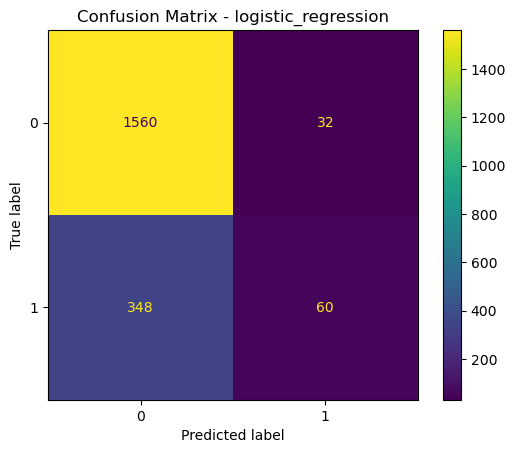

In [22]:
# Display Confusion matrix
lr_nwc_cm_plot = plot_churn_confusion_matrix(y_test=lr_nwc_num_cl["y_test"], y_pred=lr_nwc_num_cl["y_pred"], 
                                             model_name="logistic_regression")

In [23]:
# Random Forest Classification 
rf_nwc_num_cl = train_churn_classification(X_train=Xnwc_train, X_test=Xnwc_test, 
                                           y_train=y_train, y_test=y_test, model_type="random_forest")

accuracy : 0.8655, f1_score : 0.8509

Classification Report for random_forest:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1592
           1       0.80      0.46      0.58       408

    accuracy                           0.87      2000
   macro avg       0.84      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



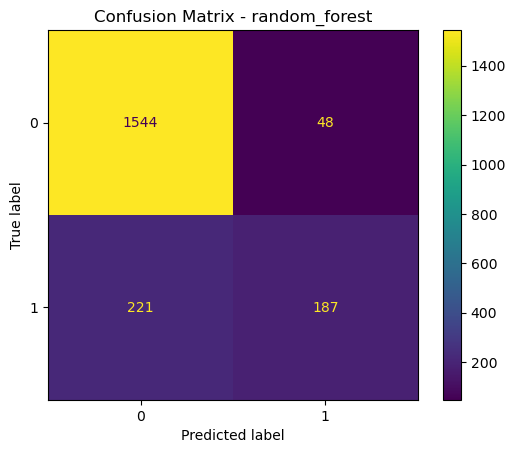

In [24]:
# Display Confusion matrix
rf_nwc_cm_plot = plot_churn_confusion_matrix(y_test=rf_nwc_num_cl["y_test"], y_pred=rf_nwc_num_cl["y_pred"], 
                                             model_name="random_forest")

In [25]:
# XGBoost Classification 
xg_nwc_num_cl = train_churn_classification(X_train=Xnwc_train, X_test=Xnwc_test, 
                                           y_train=y_train, y_test=y_test, model_type="xgboost")

accuracy : 0.8450, f1_score : 0.8329

Classification Report for xgboost:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1592
           1       0.68      0.46      0.55       408

    accuracy                           0.84      2000
   macro avg       0.78      0.70      0.73      2000
weighted avg       0.83      0.84      0.83      2000



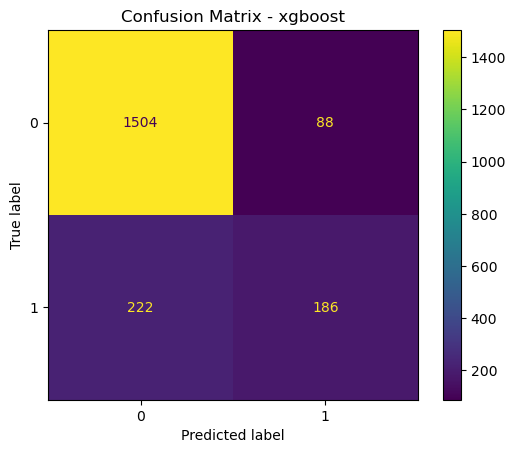

In [26]:
# Display Confusion matrix
xg_nwc_cm_plot = plot_churn_confusion_matrix(y_test=xg_nwc_num_cl["y_test"], y_pred=xg_nwc_num_cl["y_pred"], 
                                             model_name="xgboost")

The accuracy, f1_score, recall, and precision results obtained from using the numerical features without `Complain` column to predict bank customer churn (`Exited`) is reasonable with `logistic_regression` having an accuracy of (0.81), `random_forest` (0.87) and `xgboost` (0.84) as compared to when `Complain` column was applied as a feature where all the models showed a perfect (0.9985) as their accuracy. It is adviseable to stay far away from the `Complain` column for prediction on this dataset

Therefore, I will be carrying out numerical features (excluding `Column`) together with one hot encoded categorical columns (`Gender`, `Geography`, `Card Type`) to see if the model predicts better with these added features.

## Numerical and One Hot Encoded Categorical Features
- Combine both numerical (excluding `Complain`) features and one hot encoded categorical features
- Compare evaluation metrics with those of only numerical features

### OneHot encode the categorical variables
- ["Gender", "Geography", "Card Type"]

In [27]:
# Create categorical dataframe
cat_df = customer_churn_df[["Gender", "Geography", "Card Type"]].copy()

In [28]:
cat_df.head()

,Gender,Geography,Card Type
0,Female,France,DIAMOND
1,Female,Spain,DIAMOND
2,Female,France,DIAMOND
3,Female,France,GOLD
4,Female,Spain,GOLD


In [29]:
# Map the Gender column 
cat_df["Gender"] = cat_df["Gender"].map({"Female": 0, "Male": 1})

# One Hot encode Geography and Card Type columns
cat_df = pd.get_dummies(cat_df, columns=["Geography", "Card Type"], drop_first=True)

# Display the firt 5 rows to see if changes have been effected
cat_df.head()

,Gender,Geography_Germany,Geography_Spain,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,1,0,0


In [30]:
# Combine numerical features from earlier and one hot encoded columns
# Remember, we are using the one where "Complain" column was dropped
X_ncat = pd.concat([Xnwc, cat_df], axis=1)

# The target y remains the same from earlier

# Split the features into train and test sets
X_ncat_train, X_ncat_test, _, _ = train_test_split(X_ncat, y, test_size=0.2, random_state=42, stratify=y)

### Model Prediction (numerical + one hot encoded categorical features)


In [31]:
# Invoke the train_churn_classification function
# Use model_type=all to see all Model Performance Summary dataframe
all_ncat_num_cl = train_churn_classification(X_train=X_ncat_train, X_test=X_ncat_test, 
                                             y_train=y_train, y_test=y_test, model_type="all")


Model Performance Summary:
                 model  accuracy  precision  recall  f1_score
0        random_forest    0.8655   0.858178  0.8655  0.851547
1              xgboost    0.8490   0.838544  0.8490  0.840754
2  logistic_regression    0.8130   0.785476  0.8130  0.774073

Best Model: random_forest (F1-score: 0.8515, Accuracy: 0.8655)


In [32]:
# Logistic Regression Classification 
lr_ncat_num_cl = train_churn_classification(X_train=X_ncat_train, X_test=X_ncat_test, 
                                            y_train=y_train, y_test=y_test, model_type="logistic_regression")

accuracy : 0.8130, f1_score : 0.7741

Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1592
           1       0.62      0.21      0.32       408

    accuracy                           0.81      2000
   macro avg       0.73      0.59      0.60      2000
weighted avg       0.79      0.81      0.77      2000



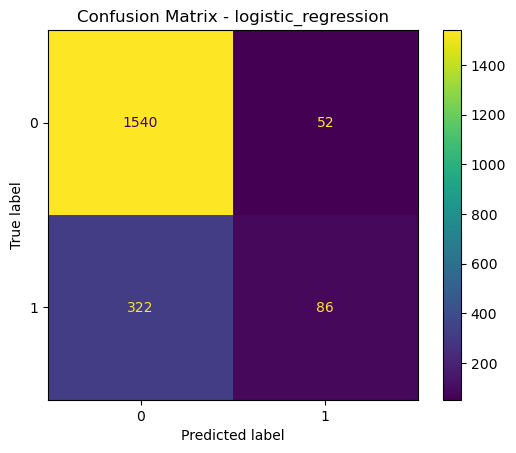

In [33]:
# Display Confusion matrix
lr_ncat_cm_plot = plot_churn_confusion_matrix(y_test=lr_ncat_num_cl["y_test"], y_pred=lr_ncat_num_cl["y_pred"], 
                                              model_name="logistic_regression")

In [34]:
# Random Forest Classification 
rf_ncat_num_cl = train_churn_classification(X_train=X_ncat_train, X_test=X_ncat_test, 
                                            y_train=y_train, y_test=y_test, model_type="random_forest")

accuracy : 0.8655, f1_score : 0.8515

Classification Report for random_forest:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1592
           1       0.79      0.47      0.59       408

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



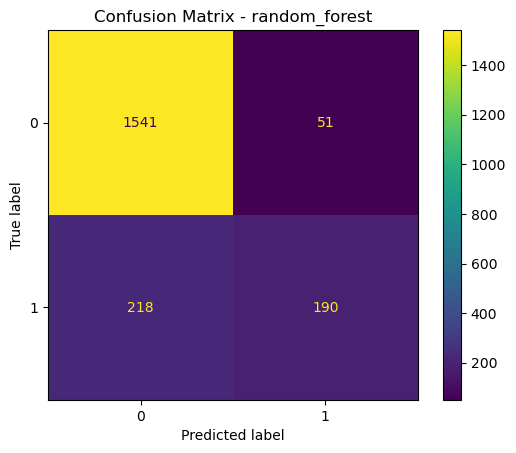

In [35]:
# Display Confusion matrix
rf_ncat_cm_plot = plot_churn_confusion_matrix(y_test=rf_ncat_num_cl["y_test"], y_pred=rf_ncat_num_cl["y_pred"], 
                                              model_name="random_forest")

In [36]:
# XGBoost Classification 
xg_ncat_num_cl = train_churn_classification(X_train=X_ncat_train, X_test=X_ncat_test, 
                                            y_train=y_train, y_test=y_test, model_type="xgboost")

accuracy : 0.8490, f1_score : 0.8408

Classification Report for xgboost:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1592
           1       0.67      0.51      0.58       408

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



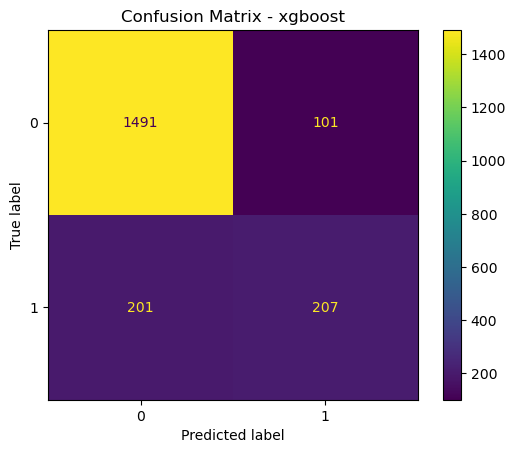

In [37]:
# Display Confusion matrix
xg_ncat_cm_plot = plot_churn_confusion_matrix(y_test=xg_ncat_num_cl["y_test"], y_pred=xg_ncat_num_cl["y_pred"], 
                                              model_name="xgboost")

The results from the models using numerical features + one hot encoded categorical features shows a slightly better result than that from models using just the numerical features. This implies that the categorical features are important features that helps predict customer churn tendencies.

**Random Forest Classifier** remained the best model amongst the three models tried out for this task `(Numerical / Numerical + One Hot encoded categorical)`. For Numerical features only, it achieved an accuracy of 0.8655 and an f1_score of 0.8509 WHILE for a combination of numerical and one hot encoded categorical features, it achieved an accuracy of 0.8655 and an f1_score of 0.8515. These improvement of model predictions when categorical features are added cut across all the tested models and more visible in the other models. 

Thereby concluding that using both numerical and categorical features enhances the predictive power of the models.

## Further digging for Insights
- Check further into the `Complain` column
- Analysis on other features with strong correlation with `Exited` 

### `Complain` Column
Why it was dropped

In [38]:
# Calculate the % of customers that exited based on complain (1) or non complaints (0)
complain_0 = customer_churn_df[customer_churn_df["Complain"] == 0]["Exited"].mean()
complain_1 = customer_churn_df[customer_churn_df["Complain"] == 1]["Exited"].mean()

# Print the result in percentage of 2 decimal places
print(f"Churn rate for customers with no complaints: {complain_0:.2%}")
print(f"Churn rate for customers with complaints: {complain_1:.2%}")

Churn rate for customers with no complaints: 0.05%
Churn rate for customers with complaints: 99.51%


In [39]:
# From the % above, it shows that only a few people who complained didn't leave
# Now let's scrutinize the customers that complained

complain_stayed = customer_churn_df[(customer_churn_df["Complain"] == 1) & (customer_churn_df["Exited"] == 0)].shape[0]
complain_exited = customer_churn_df[(customer_churn_df["Complain"] == 1) & (customer_churn_df["Exited"] == 1)].shape[0]
total_complained = complain_stayed + complain_exited

# Print customers that complained but stayed, exited
print(f"Customers with complaints but stayed : {complain_stayed}")
print(f"Customers with complaints and exited : {complain_exited}")
print(f"Total number of customers that complained : {total_complained}")

Customers with complaints but stayed : 10
Customers with complaints and exited : 2034
Total number of customers that complained : 2044


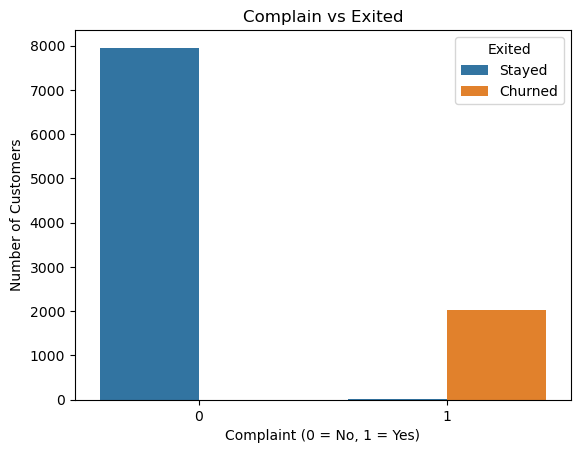

In [40]:
# Show the count plot of Complain versus Exited
sns.countplot(data=customer_churn_df, x="Complain", hue="Exited", palette="tab10")

# Add labels
plt.title("Complain vs Exited")
plt.xlabel("Complaint (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.legend(title="Exited", labels=["Stayed", "Churned"])
plt.grid(False)

# Show plot
plt.show()

Again, just like we infered from the correlation matrix from earlier, it is clear that almost;
- Every time a customer complained, they churned
- Every time a customer did not complain, they did not churn

**NB: Data Leakage: Complain was most likely recorded after customer churn had happened**

### `Age` Column
From the correlation matrix, `Age` Feature showed the strongest correlation (0.29) with the target `Exited` after the faux correlation seen by `Complain` on the target `Exited`
- Let's under study `Age`

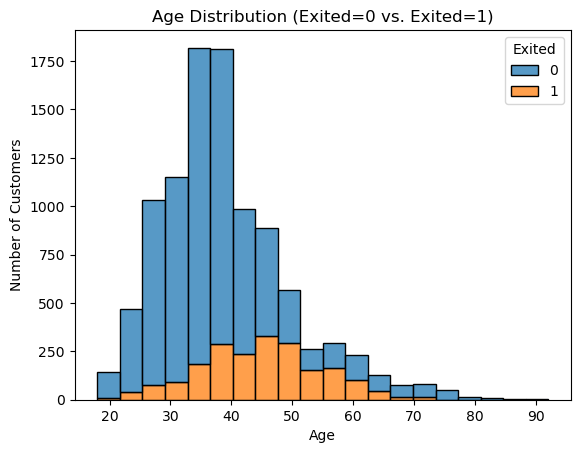

In [41]:
# Age distribution of Exited (0, 1) customers
sns.histplot(data=customer_churn_df, x="Age", hue="Exited", multiple="stack", palette="tab10", bins=20)

# Add labels
plt.title("Age Distribution (Exited=0 vs. Exited=1)")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.grid(False)

# Show plot
plt.show()

The age distribution plot above depicts that younger customers within the age of 20-30 years hardly exited the bank as seen by the orange bars. The middle-aged customers (30-45 years) are the largest customer group overall, and a noticeable amount of them are leaving the bank especially as their age increased towards 45 years as shown by the orange bars. The number of customers from age 50 and above are quite smaller but despite that, their rate of leaving were high.

General trend suggests that the likelihood of a customer to exit the bank rises with age:

- Younger people seem to be more loyal
- Old aged customers appear to be at highest risk of exiting the bank
- Middle aged customers are presently experiencing a high rate which might go higher as time goes on

### `IsActiveMember` Column
`IsActiveMember` has the second highest correlation with the target variable `Exited`, after `Age`
- Let's under study `IsActiveMember`

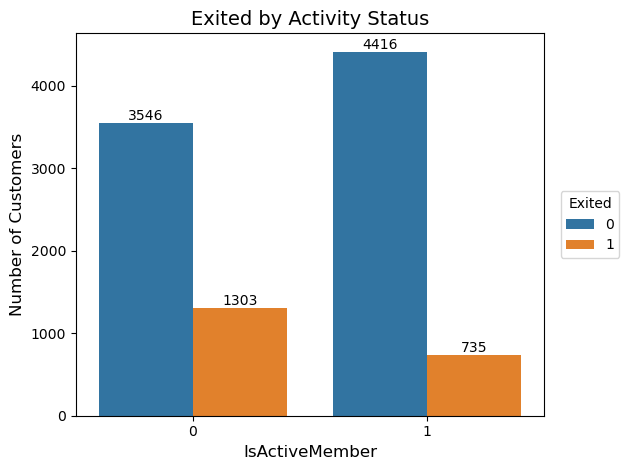

In [42]:
# Plot of customers that churned based on whether they are active or not
iam_ex_ax = sns.countplot(
    data=customer_churn_df,
    x="IsActiveMember",
    hue="Exited",
    palette="tab10"
)

# Add title and labels
plt.title("Exited by Activity Status", fontsize=14)
plt.xlabel("IsActiveMember", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# On top off bars, add value labels
for container in iam_ex_ax.containers:
    iam_ex_ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

# Move the legend to the right side
iam_ex_ax.legend(title="Exited", bbox_to_anchor=(1.02, 0.5), loc='center left')

# Add layout and show plot
plt.tight_layout()
plt.show()

The count plot above showed customers stance towards the bank based on their activity status. A customer is likely to leave when they are inactive, i.e, inactive customers are more liable to leave the bank at a higher rate unlike the active members. 

## Recommendation

The classification models performed well in predicting bank customers that churned. Advice to the bank team would be to record complaints and act on them before customers churn and not after they have churned so that data leakage that bias model prediction will be avoided.

For better customer retention, the following systems need to be put in place or improved by the bank based on the exploratory analysis carried out;

- **Complaint Management system:** Complaints should be worked upon as early as they are received. Effecting this approach will gain customers trust as complaints will be quickly resolved, leading to customer satisfaction.

- **Loyalty Program:** Middle aged customers whose rate of leaving the bank are becoming increasingly high should be tackled through the introduction of loyalty programs such as lifestyle perks, better interest rates or community engagement events. The old aged customers who are already leaving in droves can be reduced by juicy retirement plans like health and wellness packages, and safe investment bundles.

- **Bonuses for active customers:** Banks should attach nice perks to customers who engage the bank through frequent transactions or deposits. There should also be promotions for inactive customers inorder to bring them back onboard.